# Batsim Demo

Here is a simple example of how you can run Batsim and analyse the results.

## Simulation

The following section shows how to simulate an scenario with Batsim.

### Gather parameters

In order to run Batsim you'll need a platfom definition and a workload. We provide several sample platforms under the *platforms* directory. Same happens for workloads, which are located under *workloads* directory.

Here we will use the following configurations:
- Platform: *energy_platform_homogeneous_no_net_128.xml*
- Workload: *workload_hpc_seed{1,2,3,4,5}_jobs250.json*

We will also try to compare different policies implemented by Batsched:

In [1]:
policies = ["fcfs_fast", "easy_bf_fast", "easy_bf" ]

### Generate experiment description

To be able to run the scheduler and the simulator process with one command, Batsim need his faithful Robin!

Note that you can run the batsim command and the batsched command in two terminals by hand or putting one process in backgroud with `&`:

```sh
export policy=fcfs_fast
export seed=2
batsim -p ../platforms/energy_platform_homogeneous_no_net_128.xml \
       -w ../workloads/workload_hpc_seed${seed}_jobs250.json -v quiet -e ${policy} &
batsched -v ${policy}
```

Jupyter notebooks are not capable of running two process in parallel right now, so let's use Robin :)

First we generate yaml files:

In [2]:
%%bash -s "{" ".join(policies)}"
for policy in $1
do
for seed in $(seq 5)
do
cat <<EOF > expe_${policy}_${seed}.yaml  
batcmd: batsim -p ../platforms/energy_platform_homogeneous_no_net_128.xml -w ../workloads/workload_hpc_seed${seed}_jobs250.json -v quiet -e ${policy}_${seed}
output-dir: ${policy}_${seed}
schedcmd: batsched -v ${policy}
simulation-timeout: 30
ready-timeout: 5
success-timeout: 5
failure-timeout: 0
EOF
echo "# expe_${policy}_${seed}.yaml created!"
done
done

# expe_fcfs_fast_1.yaml created!
# expe_fcfs_fast_2.yaml created!
# expe_fcfs_fast_3.yaml created!
# expe_fcfs_fast_4.yaml created!
# expe_fcfs_fast_5.yaml created!
# expe_easy_bf_fast_1.yaml created!
# expe_easy_bf_fast_2.yaml created!
# expe_easy_bf_fast_3.yaml created!
# expe_easy_bf_fast_4.yaml created!
# expe_easy_bf_fast_5.yaml created!
# expe_easy_bf_1.yaml created!
# expe_easy_bf_2.yaml created!
# expe_easy_bf_3.yaml created!
# expe_easy_bf_4.yaml created!
# expe_easy_bf_5.yaml created!


### Do the actual simulation

In [3]:
for policy in policies:
    for seed in range(1, 6):
        !robin expe_{policy}_{seed}.yaml --quiet
print("Done!")

Done!


## Analysis

Let's now compare our two scheduling policies with Evalys Python library that provides analysis and visualisation tools for the Batsim output (and traces, transformation, utils...).

### Metrics comparison

There are several metrics calculated by Batsim on the fly during the simulation, so you don't have to do it by yourself afterwards. These metrics are stored in a CSV file called `${prefix}_schedule.csv`.
 
Fist, let's load these files to see some metrics:

In [4]:
import pandas

metrics = pandas.DataFrame()
for policy in policies:
    for seed in range(1, 6):
        df = pandas.read_csv("{}_{}_schedule.csv".format(policy, seed))
        df = df.assign(policy = policy)
        df = df.assign(workload = seed)
        metrics = metrics.append(df, ignore_index=True)

metrics

batsim_version  consumed_joules      makespan  max_slowdown  \
0          v2.0.0              0.0  11304.243341     23.744978   
1          v2.0.0              0.0  11216.327828     23.591373   
2          v2.0.0              0.0  14234.577563     55.237706   
3          v2.0.0              0.0  11945.364187     19.775458   
4          v2.0.0              0.0  11300.417491     14.396294   
5          v2.0.0              0.0  11412.099563     22.470176   
6          v2.0.0              0.0  11146.306618     23.496010   
7          v2.0.0              0.0  15062.771125     66.484001   
8          v2.0.0              0.0  11945.364187     30.864080   
9          v2.0.0              0.0  11275.057491     14.561256   
10         v2.0.0              0.0  11187.138350     25.288731   
11         v2.0.0              0.0  10931.354016     22.773245   
12         v2.0.0              0.0  12528.305072     34.263482   
13         v2.0.0              0.0  11945.364187     11.677113   
14         v2.0.0              0.0  11275.057491     15.633719   

    max_turnaround_time  max_waiting_time  mean_slowdown  \
0           2611.375499       1806.549952       4.977482   
1           3583.537694       2143.047694       5.493117   
2           5727.658447       4281.628447      13.791670   
3           3047.891420       1853.024361       3.424947   
4           2305.348799       1059.938490       2.555885   
5           3075.711720       2205.948891       2.003687   
6           3608.676484       2168.186484       4.577121   
7           6555.852009       5150.971525       6.349471   
8           3703.942420       2349.108551       1.832767   
9           2293.706386       1248.268921       2.241201   
10          2772.090507       1910.551545       1.797703   
11          3571.783883       2131.293883       3.635228   
12          4021.385956       3395.774673       2.400366   
13          2829.650657       1438.310766       1.755261   
14          2378.066386       1151.088374       1.987339   

    mean_turnaround_time  mean_waiting_time  nb_computing_machines    ...     \
0             715.667108         514.423988                    128    ...      
1             834.765552         626.573792                    128    ...      
2            1945.343811        1746.187411                    128    ...      
3             522.627279         326.302719                    128    ...      
4             422.254437         220.007557                    128    ...      
5             369.851450         168.608330                    128    ...      
6             708.063669         499.871909                    128    ...      
7            1010.010380         810.853980                    128    ...      
8             332.739486         136.414926                    128    ...      
9             375.576478         173.329598                    128    ...      
10            315.138336         113.895216                    128    ...      
11            591.942392         383.750632                    128    ...      
12            437.626596         238.470196                    128    ...      
13            310.942599         114.618039                    128    ...      
14            343.137216         140.890336                    128    ...      

    scheduling_time  simulation_time  success_rate  time_computing  \
0          0.139998         0.565850           1.0       969575.04   
1          0.127429         0.430601           1.0      1027489.32   
2          0.146494         0.455964           1.0      1063940.24   
3          0.155324         0.506908           1.0       997568.08   
4          0.131283         0.434197           1.0       892692.44   
5          0.127099         0.436741           1.0       969575.04   
6          0.135773         0.451364           1.0      1027489.32   
7          0.130689         0.429210           1.0      1063940.24   
8          0.127764         0.421524           1.0       997568.08   
9   

You can see that there is a lot of information here, from the Batsim version to scheduling, power and usage metrics.
We also inject the workload seed number and the policy used.

You can get the list of all the available information with:

In [5]:
list(metrics.columns)

['batsim_version',
 'consumed_joules',
 'makespan',
 'max_slowdown',
 'max_turnaround_time',
 'max_waiting_time',
 'mean_slowdown',
 'mean_turnaround_time',
 'mean_waiting_time',
 'nb_computing_machines',
 'nb_grouped_switches',
 'nb_jobs',
 'nb_jobs_finished',
 'nb_jobs_killed',
 'nb_jobs_success',
 'nb_machine_switches',
 'scheduling_time',
 'simulation_time',
 'success_rate',
 'time_computing',
 'time_idle',
 'time_sleeping',
 'time_switching_off',
 'time_switching_on',
 'policy',
 'workload']

Now let's compare the two policies on our different workloads:

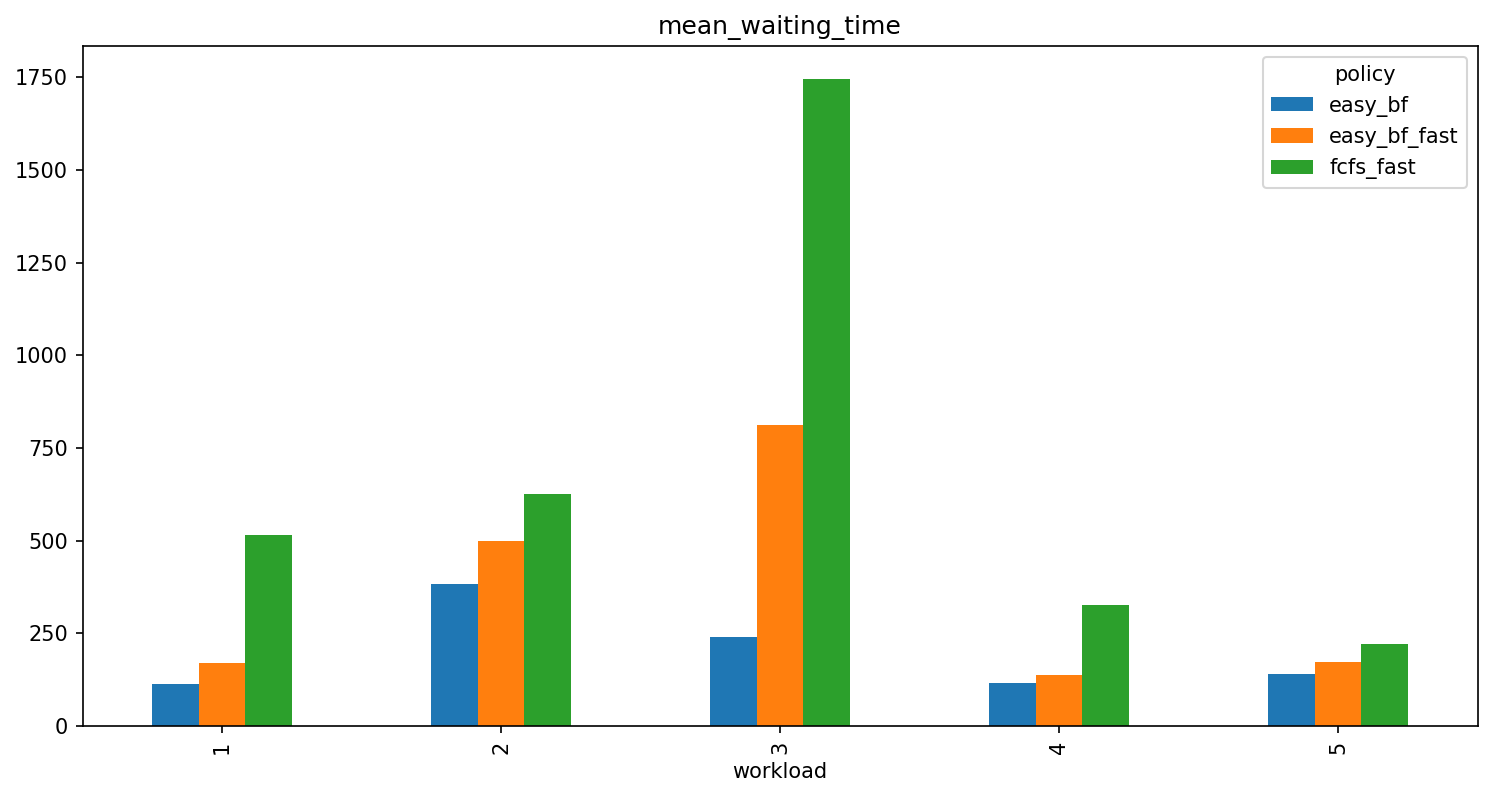

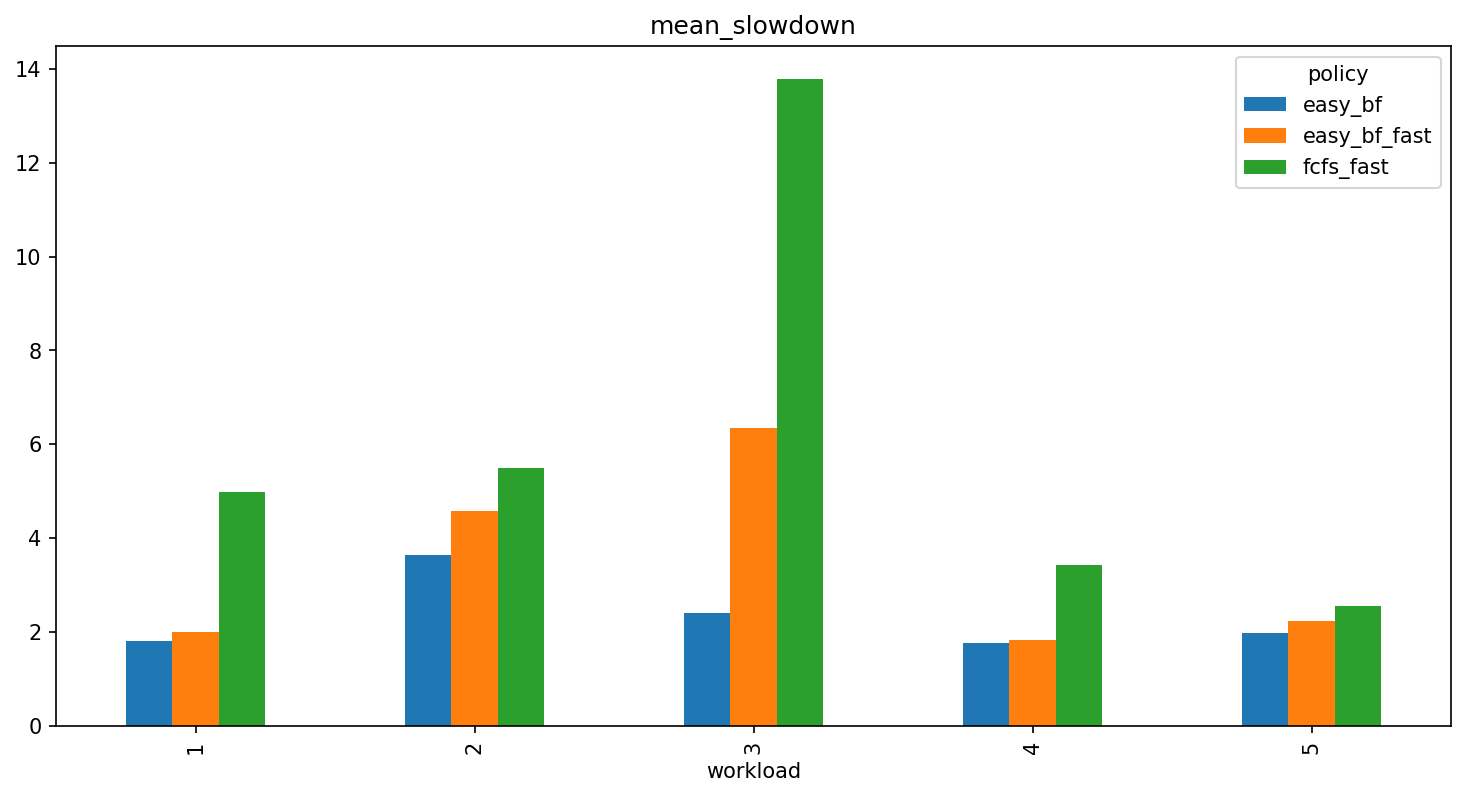

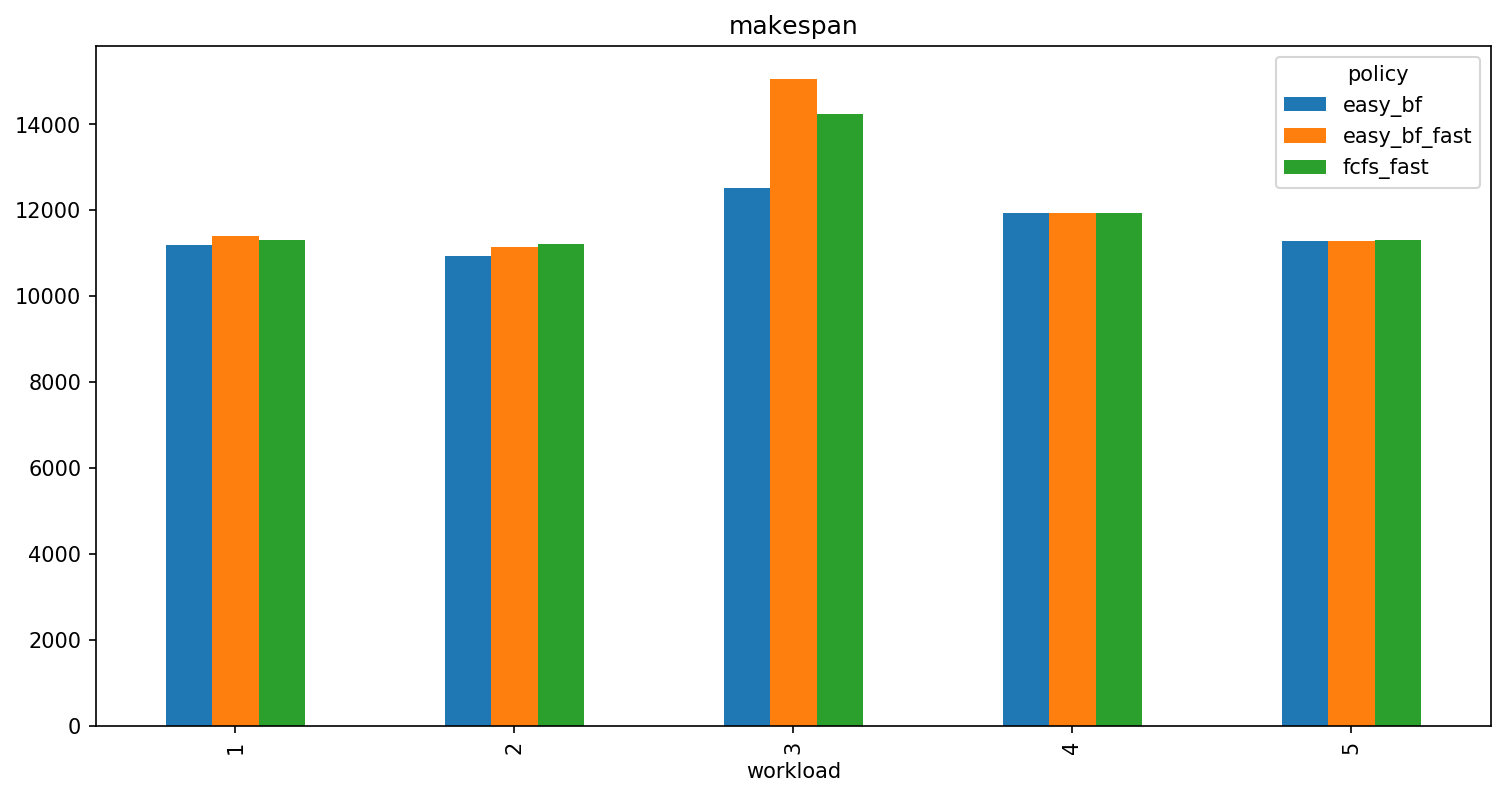

In [6]:
# Get bigger and nicer graph
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 12,6
matplotlib.rcParams['figure.dpi']= 150

for metric in ["mean_waiting_time", "mean_slowdown", "makespan"]: 
    metrics.groupby(["workload","policy"])[metric].mean().unstack().plot.bar(title=metric)


As expected, *Easy Backfilling* is much better in terms of **waiting time** and **slowdown**. But, it is interesting to see that the **makespan** is not so much impacted by the policy.

### Detailed visualization

In the Batsim ecosystem lives Evalys. Evalys is a Python library that facilitates Batsim (and SWF) trace loading, processing, and visualization. Let's import it and have a detailed look at one of the traces, for example the *workload 3* that seems to be an outlier.

In [7]:
%matplotlib inline
from evalys.jobset import JobSet
import matplotlib
import matplotlib.pyplot as plt

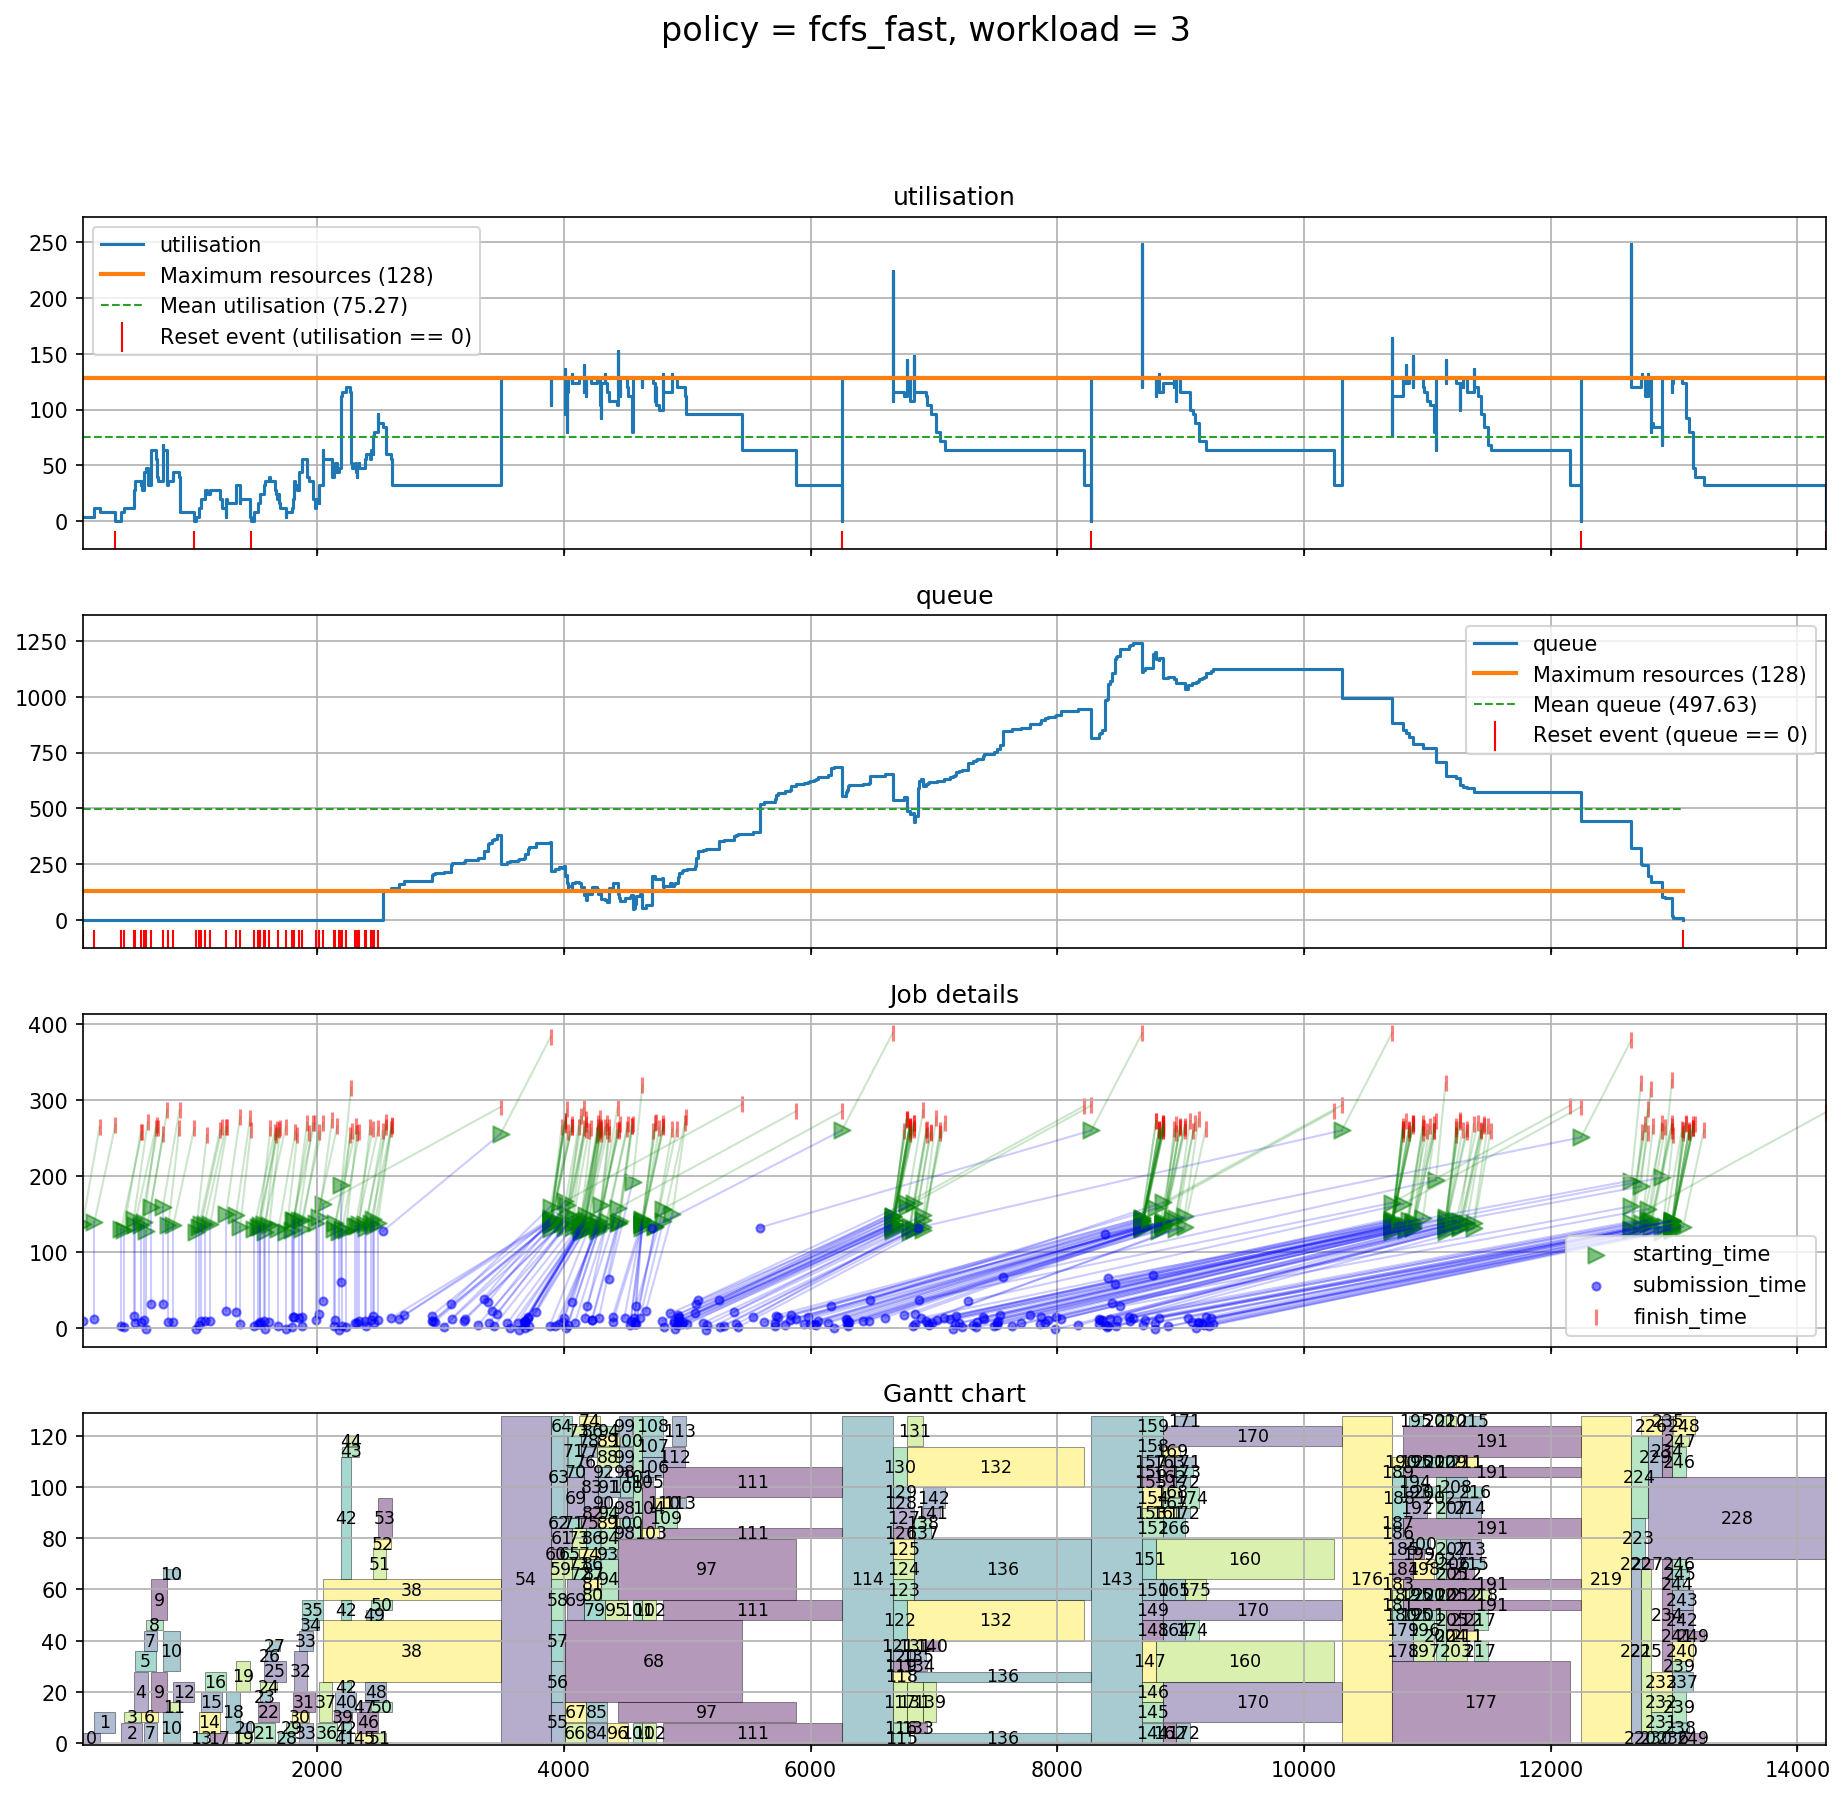

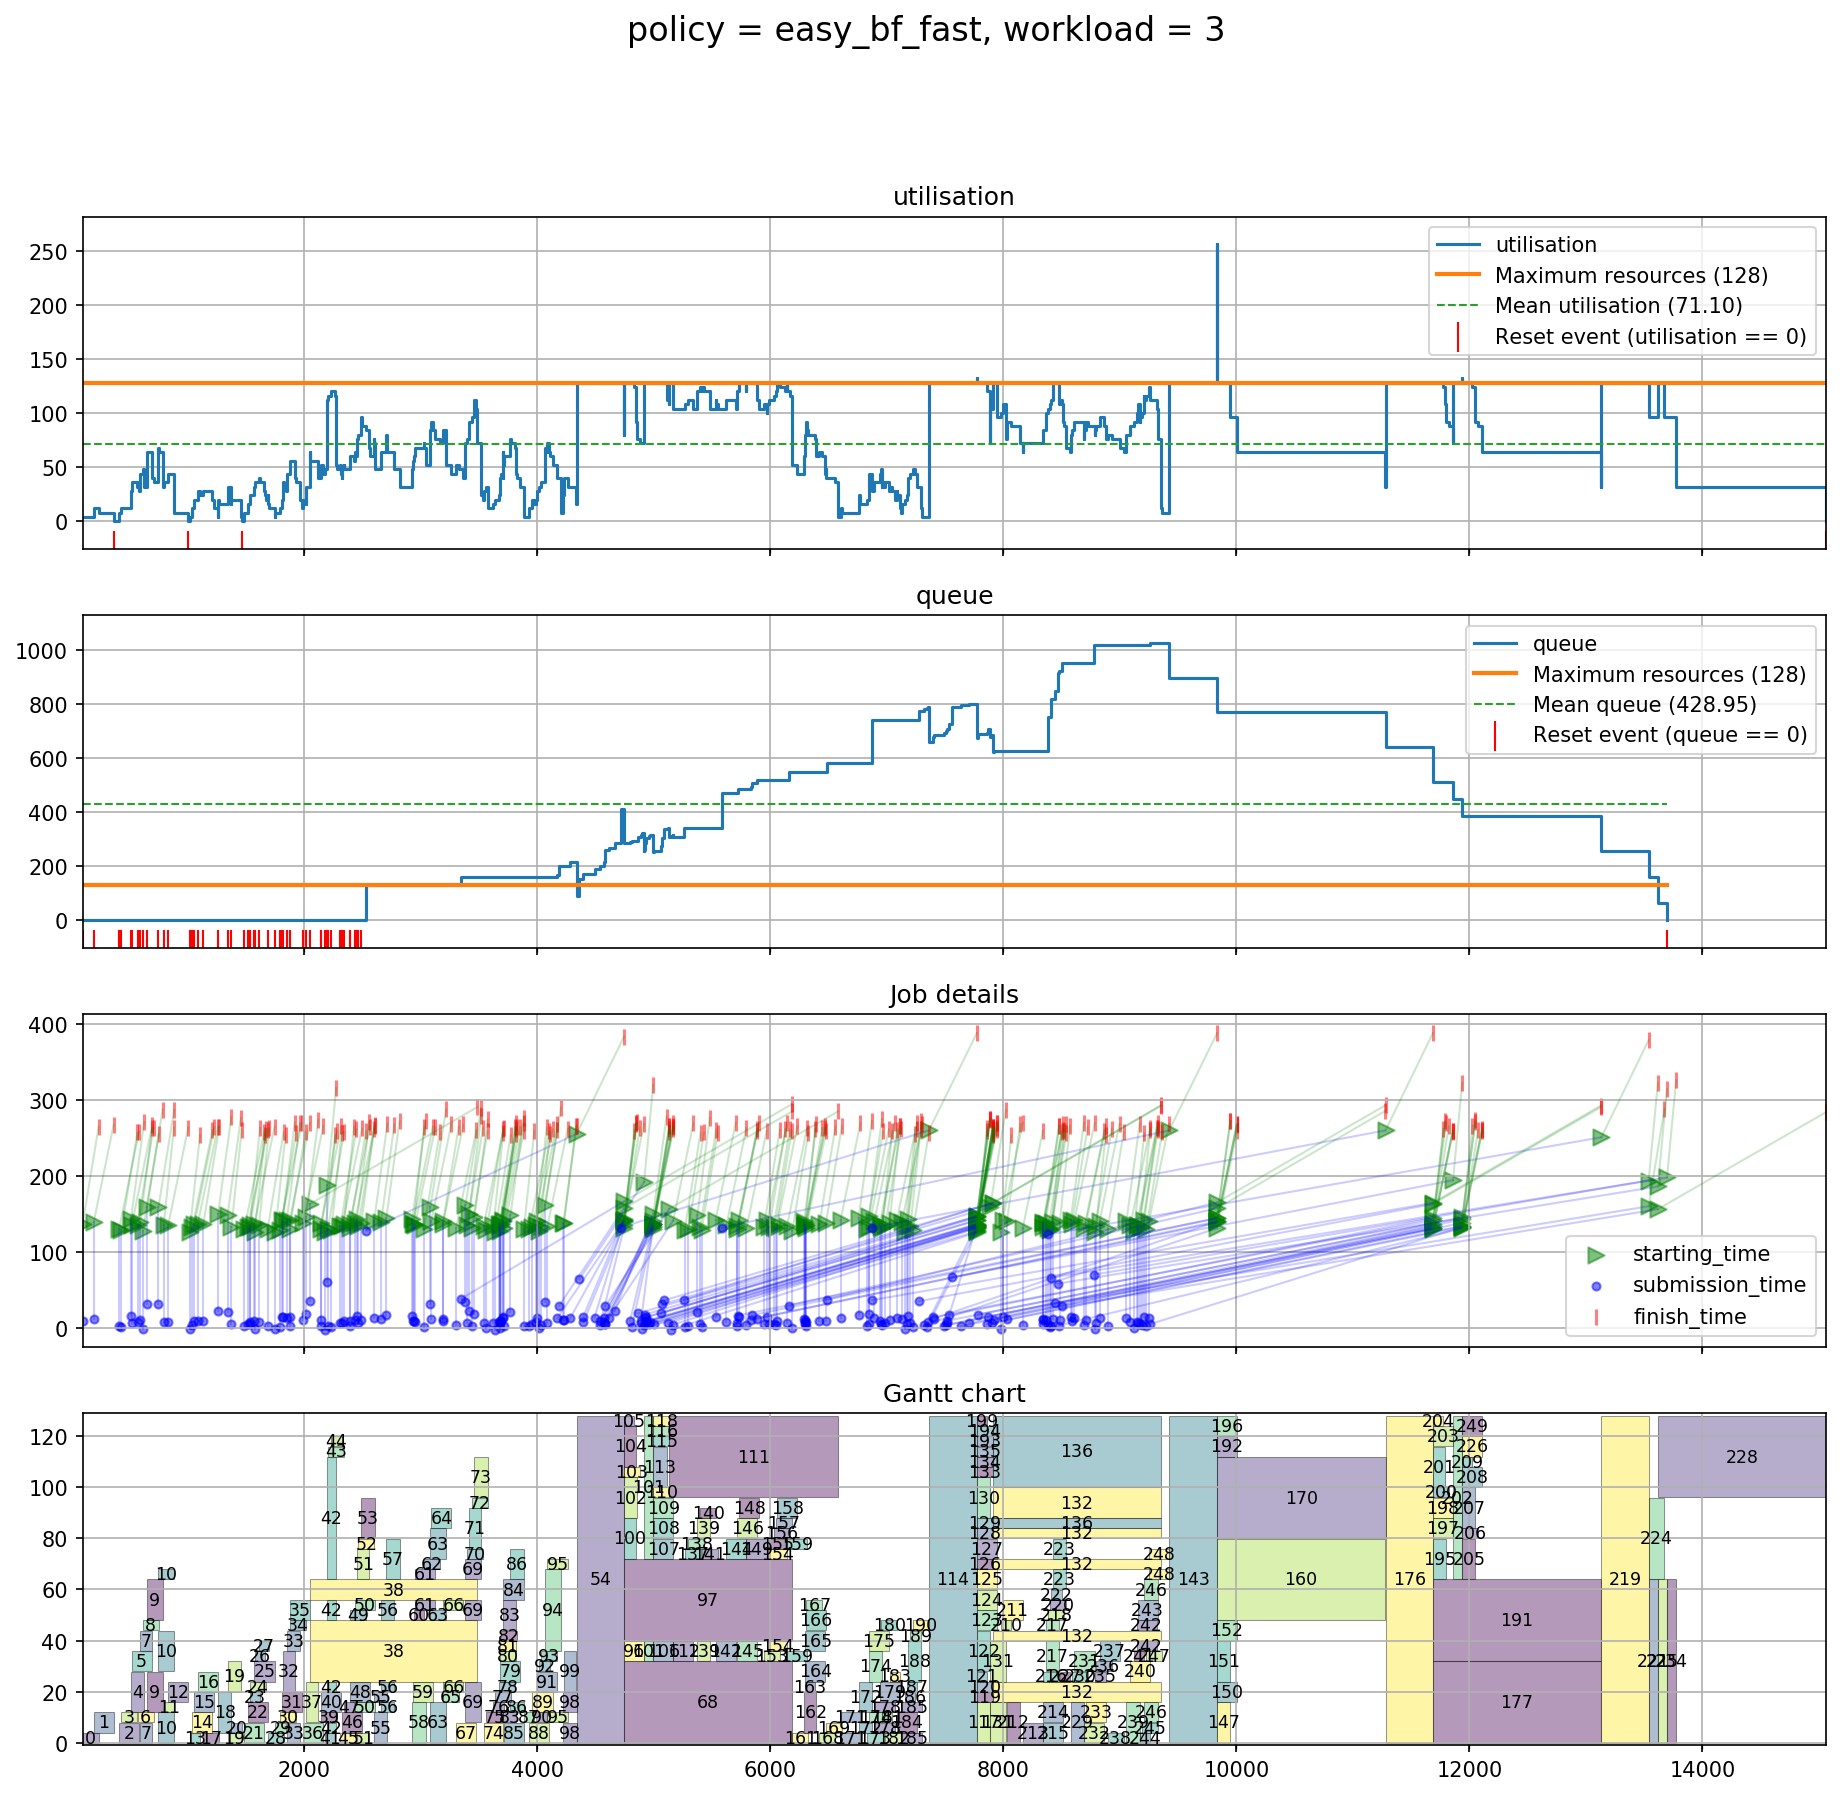

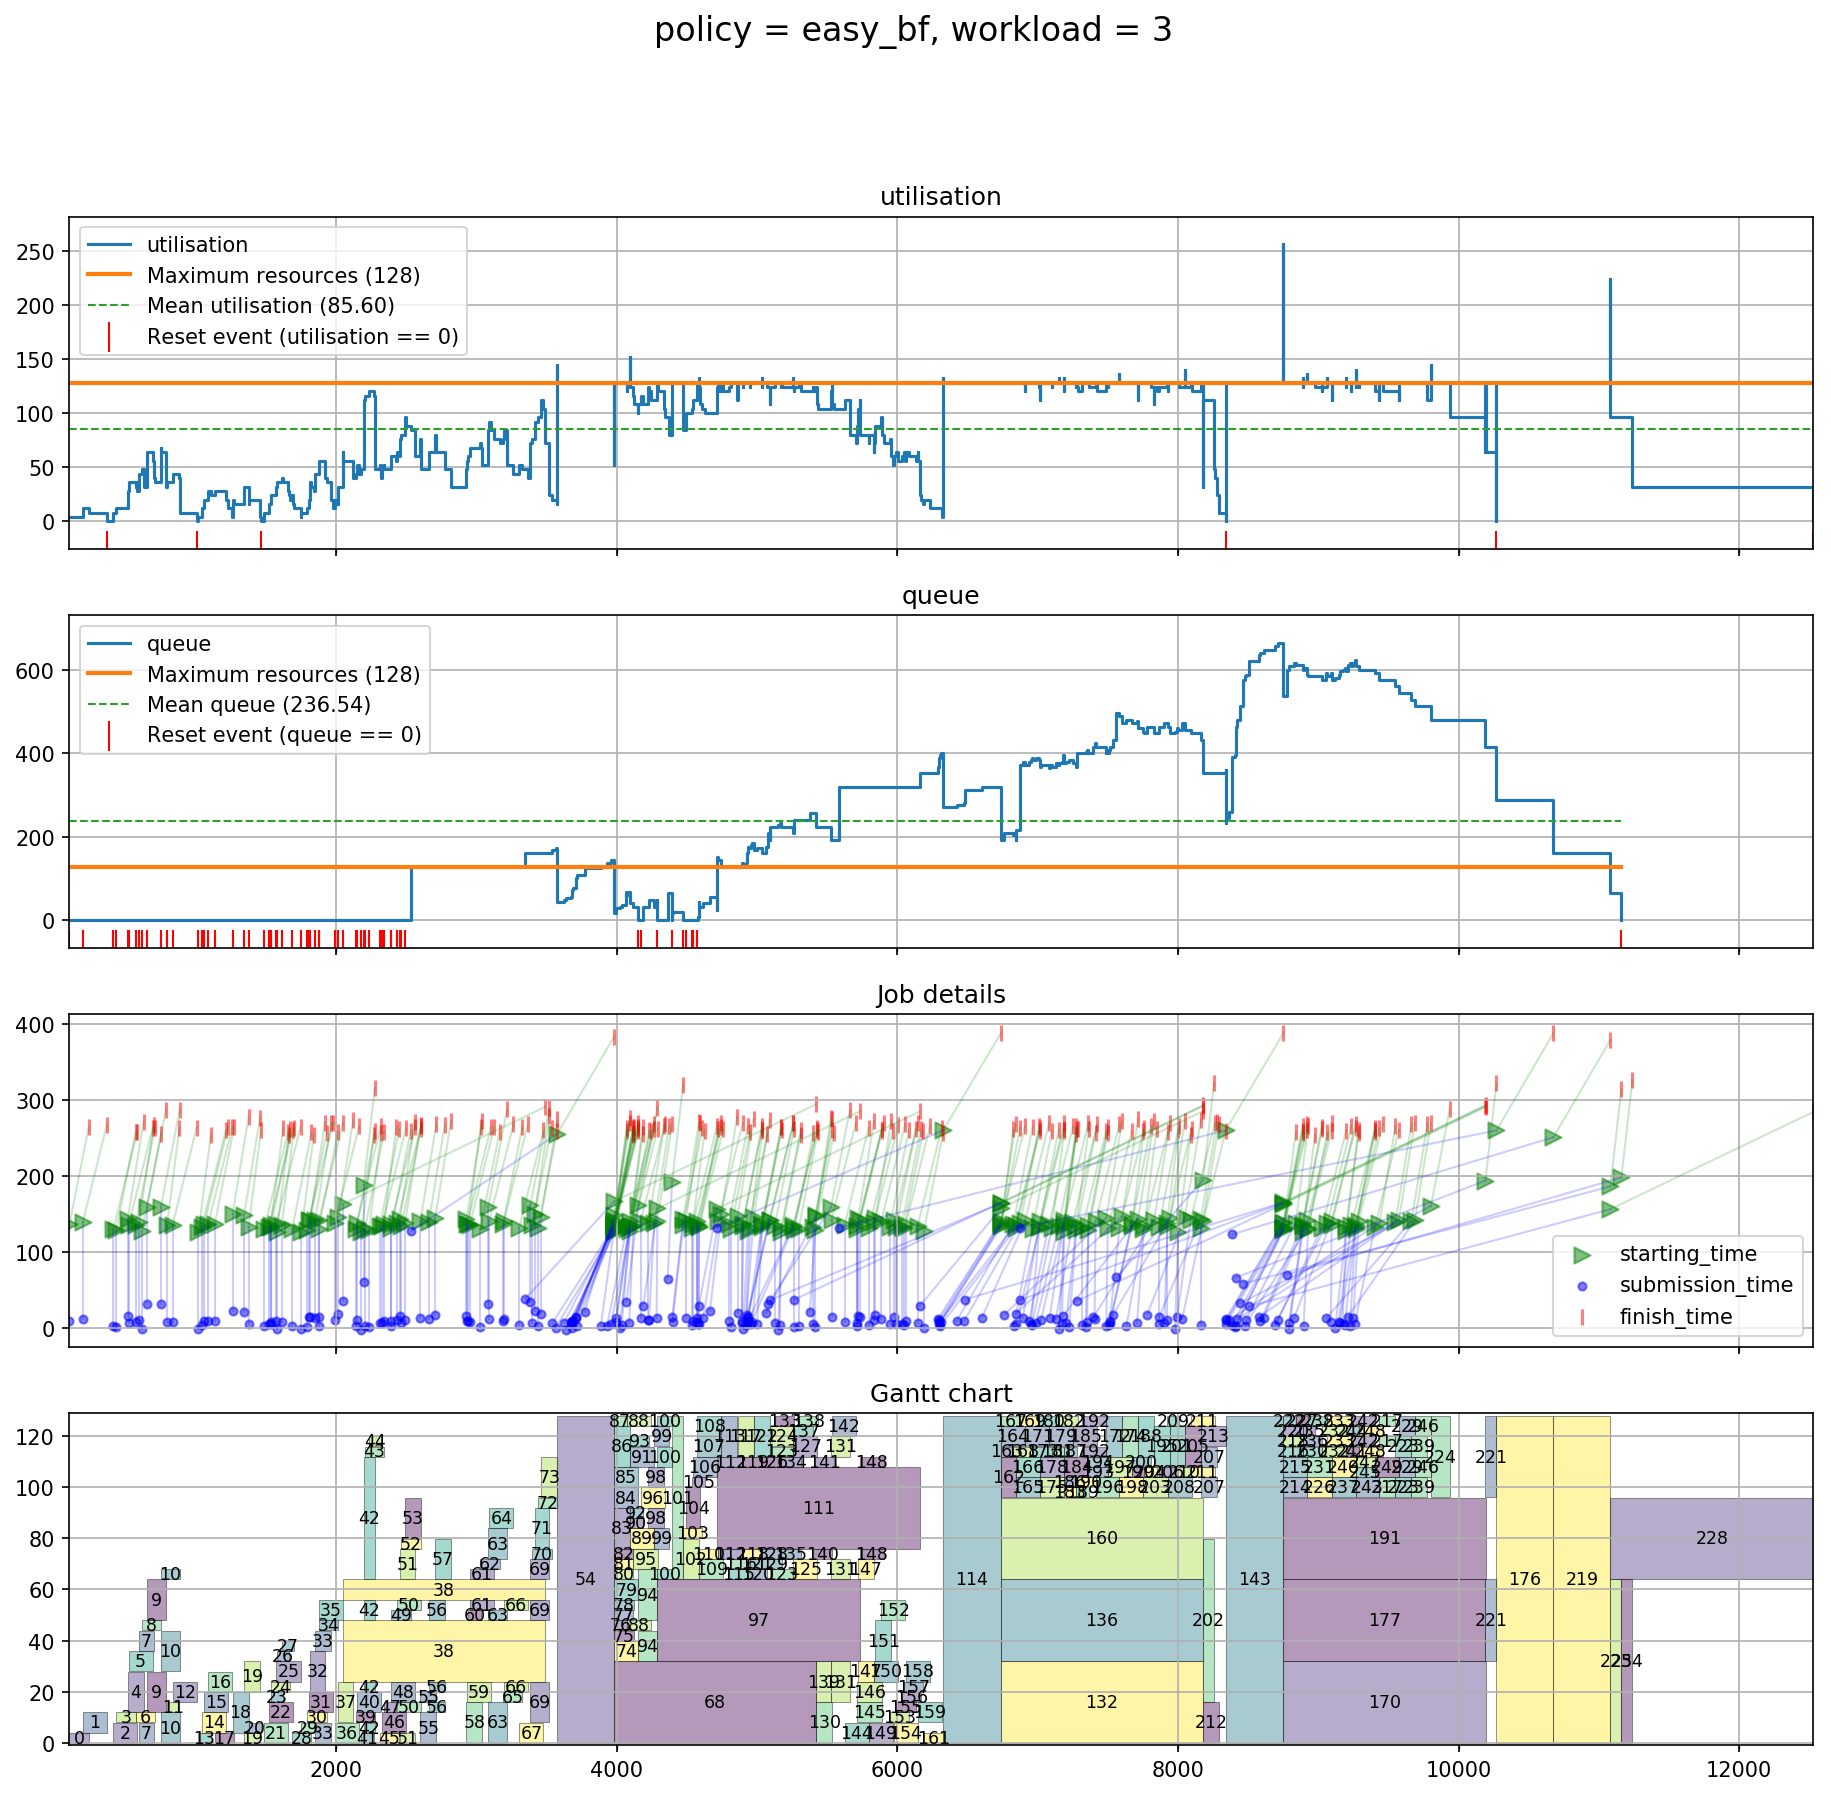

In [8]:
# Get bigger and nicer graph
matplotlib.rcParams['figure.figsize'] = 15, 13.5
matplotlib.rcParams['figure.dpi']= 150

# Let's explore seed 3 for all policies
seed = 3

js = {}
for policy in policies:
    js[policy] = JobSet.from_csv("./{}_{}_jobs.csv".format(policy, seed))
    js[policy].plot(with_details=True, title="policy = {}, workload = {}".format(policy, seed))
    plt.savefig("{}_{}_details.pdf".format(policy, seed))

#### Details visualization explained

Those 4 graphs deserved a small explanation. All of them share the same X axis, which is the time in
seconds.  The Y axis of all those graphs is a number of resources, here a machine (a.k.a. compute node).

This **utilisation** graph shows the number of resources used by a
job over time. With the yellow line being the maximum number of resources. Note
that sometimes the utilisation goes upper the yellow line but it is just a
visualization artefact due to events seen as simultaneous due to rounding.

The **queue** graph is the sum of all the resources requested by all the jobs in the
queue over time. It represents the load of the cluster.

The **job details** visualization (based on an original idea of David
Glesser) is the one most interesting, but it needs some explanation to
be understandable. Each job is represented by 3 elements joined by lines. The
first element is a blue dot that correspond to the submission time, the green
triangle is the starting time and red bar the finish time. Those 3 elements are
not aligned because of job interference. Each element is separated by the total number of
resources (here 128) and they are all translated by the number of requested
resources. It means that the bigger the job is in number of resources, the
upper the 3 elements are translated. It's worth noting that we can observe job's
waiting time by observing their blue lines verticality: if a job doesn't wait,
its blue line is vertical and the more a job is waiting the more the blue line
becomes horizontal. The same observation can be taken from the job's runtime and
the green line.

The **Gantt chart** visualization is showing where and when each
job has run during the simulation. It has to be correlated with the topology,
with a mapping between node IDs and node positions on the topology to fully
understand allocation policies.



### Detailed comparison

Ok, now that we have seen what's happening in detail we can compare the two detailed views with each other to be able to do a fine grain comparison of policy choices.

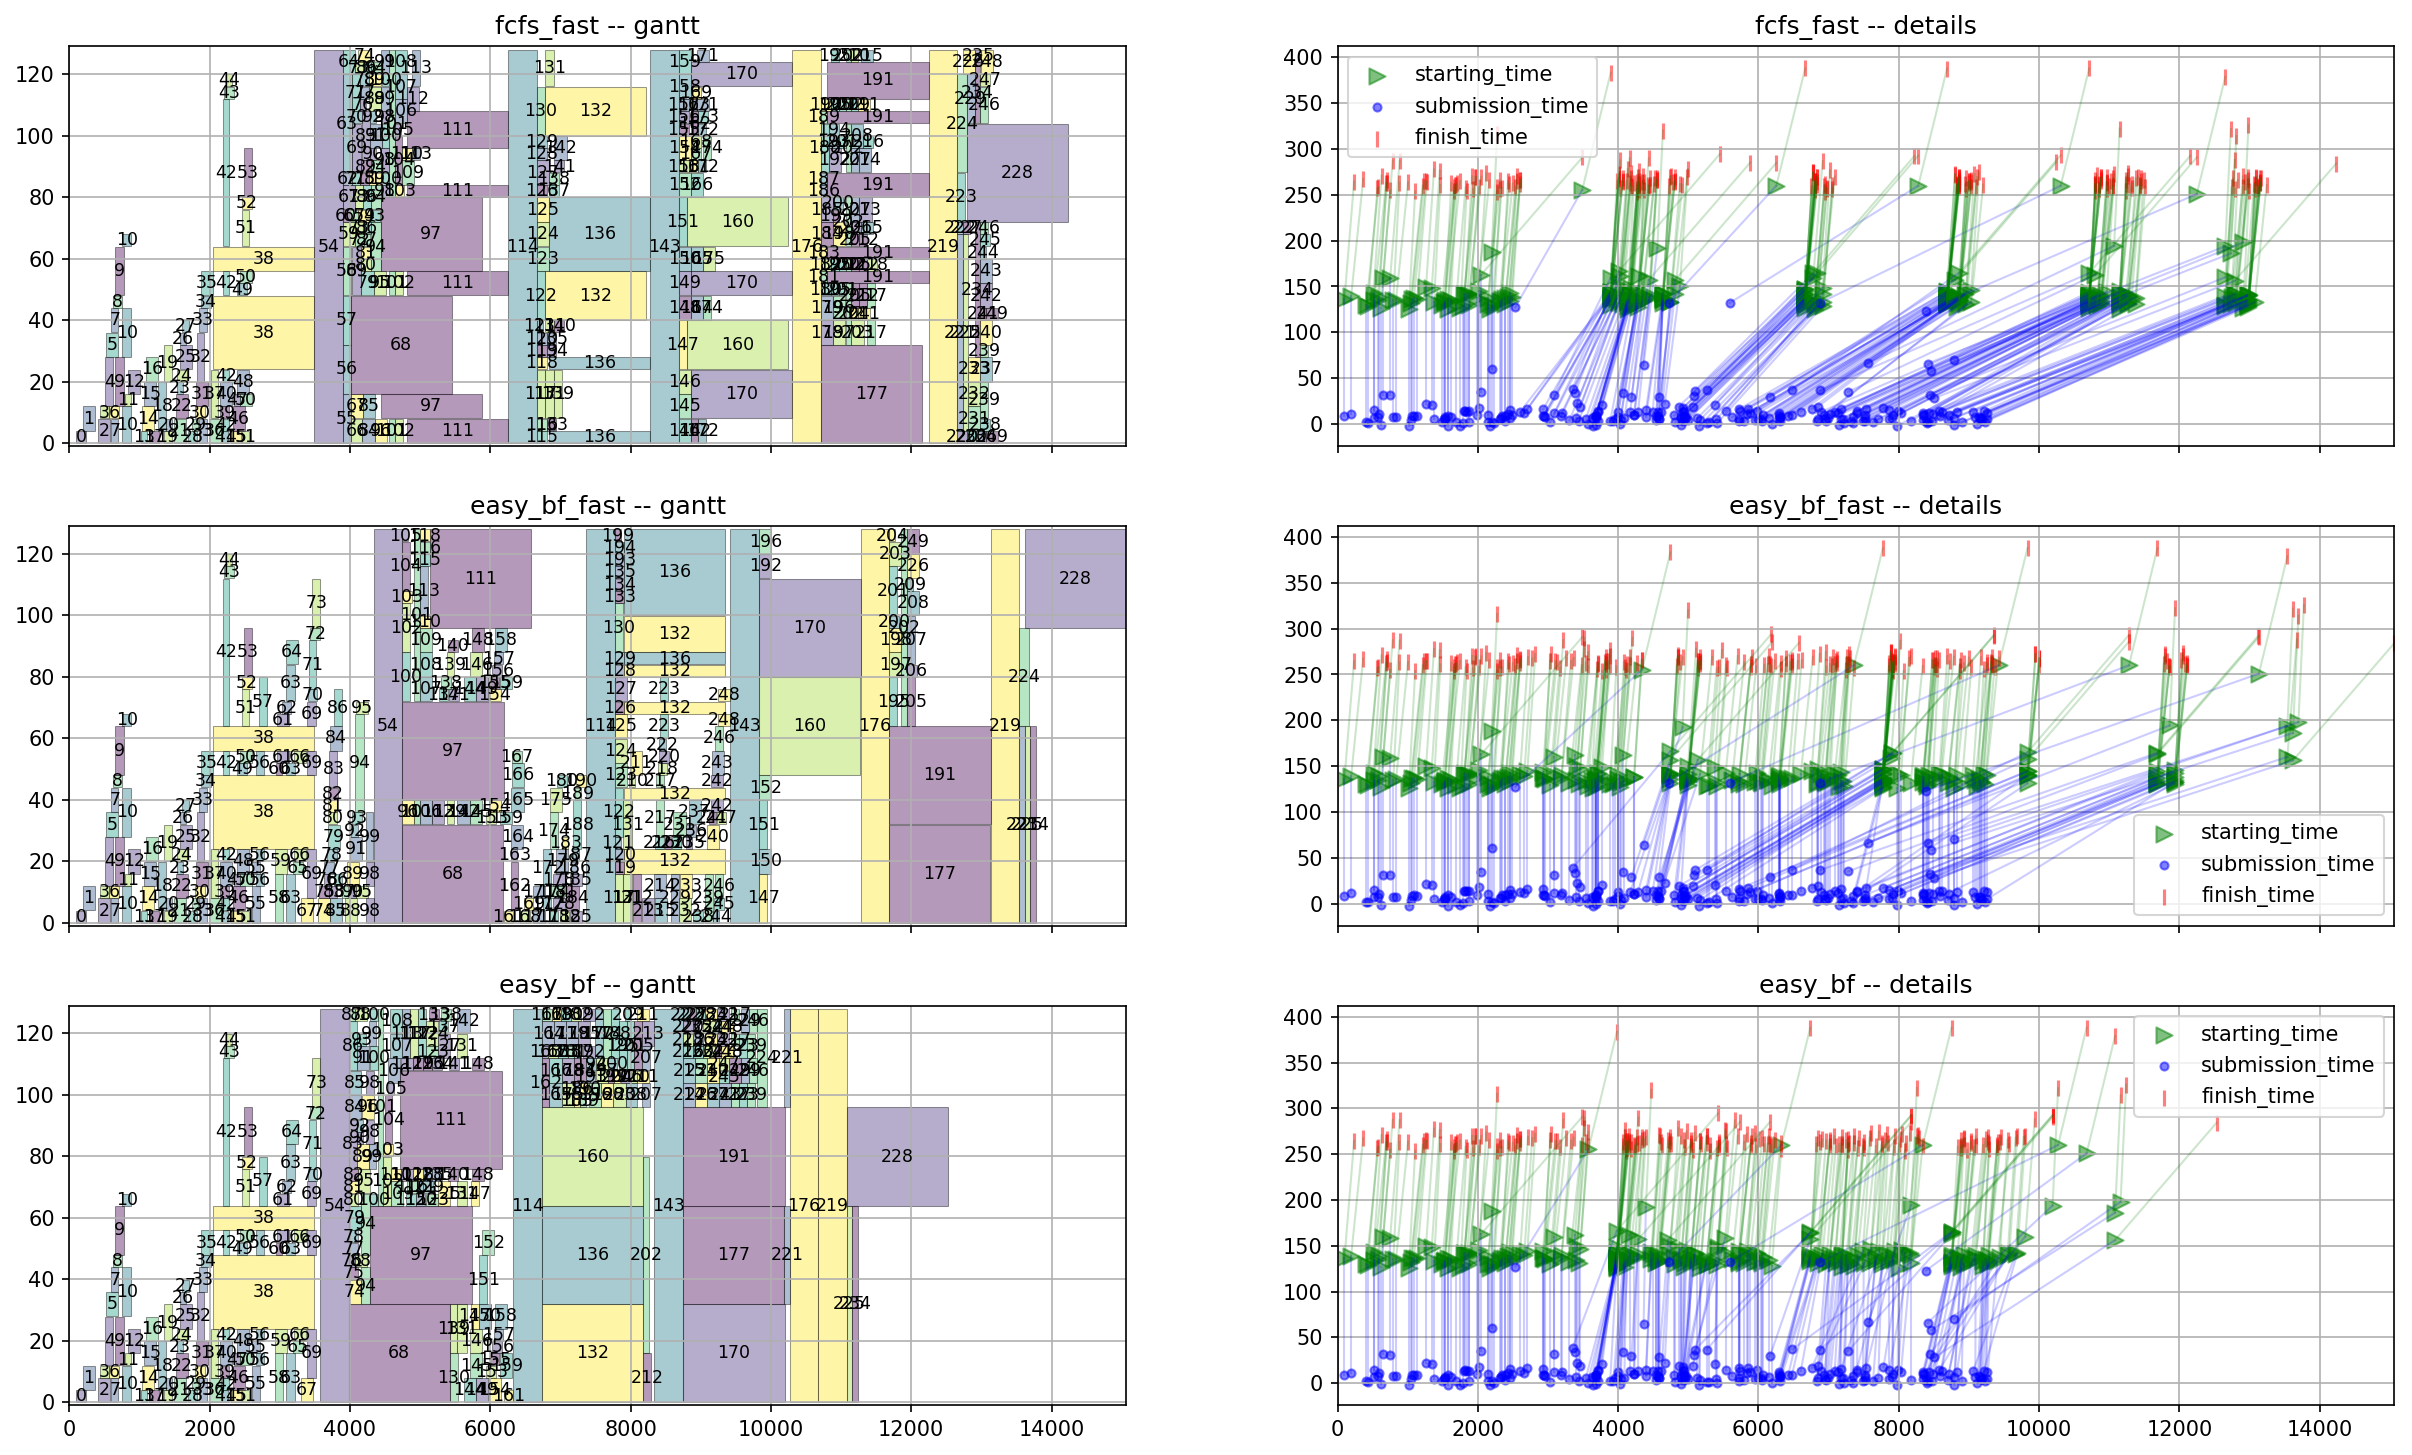

In [9]:
import matplotlib.pyplot as plt
from evalys import visu

matplotlib.rcParams['figure.figsize'] = 20, 12
matplotlib.rcParams['figure.dpi']= 150

fig, axes = plt.subplots(nrows=len(policies), ncols=2, sharex=True)

for i, policy in enumerate(policies):
    visu.plot_gantt(js[policy], ax=axes[i][0], title=policy + " -- gantt")
    visu.plot_job_details(js[policy].df, ax=axes[i][1], size=128, title=policy + " -- details")

# Get max values of all graphs to set the x limit properly
max_finish_time = [max(js[policy].df.finish_time) for policy in policies]
[axe.set_xlim([0, max(max_finish_time)]) for sublist in axes for axe in sublist]

plt.savefig("easy_fcfs_comparision_details.pdf")

### Analysis conclusion

With this compared visualization we can easily see that the `easy_bf` policy has a much more efficient backfilling policy than `easy_bf_fast`, even if `easy_bf_fast` is better than the `fcfs` baseline in waiting time but not in makespan.

## Demo Conclusion

With this notebook you have a full example of what can be achieved with Batsim and all it's ecosystem: Batsched for baseline policies comparison, Robin to help you run a lot of experiments, and of course Evalys that helps you in understanding the outputs of your experiments.